# Этап 0. Информация о проекте

## Исследование закономерностей успешной игры

В интернет-магазине «Стримчик», который продает компьютерные игры, задумали провести исследование о наличии закономерностей продаж для успешной игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности, сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Этап 1. Получение данных

Изучим данные, предоставленные сервисом для проекта.

## Импорт библиотек

In [1]:
# Импортируем pandas, matplotlib.pyplot, numpy, math, seaborn, scipy.stats. 
# Анализ предстоит основательный, нужно больше библиотек!

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math 
from scipy import stats as st
import seaborn as sns
from scipy.stats import t

Прочитаем файл *games.csv* и сохраним его в переменной *games*. 

In [2]:
games = pd.read_csv('/datasets/games.csv')

Установим максимальное число видимых строк и столбцов 100

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Выведем общую информацию о данных таблицы games.

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 11 столбцов.
Подробно разберём, какие в *games* столбцы и какую информацию они содержат:

* Name — название игры, тип данных object соответсвует представленной информации
* Platform — платформа, тип данных object соответсвует представленной информации
* Year_of_Release — год выпуска, тип данных float64, будем менять на int, а не на dtype чтобы при группировке pivot_table, не появилась лишняя информация вида 01.01.YY
* Genre — жанр игры , тип данных object соответсвует представленной информаци
* NA_sales — продажи в Северной Америке (миллионы долларов), тип данных float соответсвует представленной информаци
* EU_sales — продажи в Европе (миллионы долларов), тип данных float соответсвует представленной информаци
* JP_sales — продажи в Японии (миллионы долларов), тип данных float соответсвует представленной информаци
* Other_sales — продажи в других странах (миллионы долларов), тип данных float соответсвует представленной информаци
* Critic_Score — оценка критиков (максимум 100), тип данных float соответсвует представленной информаци
* User_Score — оценка пользователей (максимум 10), тип данных object, будем менять на float
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию, тип данных object соответсвует представленной информаци

Количество значений в столбцах различается. Это говорит о том, что в данных есть пустые значения.

**Выводы**

Каждая строка таблицы содержит информацию о игре определённого жанра,платформу и год выпуску, ее продаже по разным регионам, рейтингу критиков и пользователей. Две проблемы, которые нужно решать: пропуски и заглаыные буквы в названиях столбцов. Для предстоящего анализа все столбцы важны, постораемся не потерять много данных.

# Этап 2. Предобработка данных

**Заменим названия столбцов.** 

Сначала приведем их к нижнему регистру методом .str.lower()

In [5]:
games.columns.str.lower()

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Делаем замену методом .set_axis()

In [6]:
games.set_axis(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],axis = 'columns',inplace = True)

Смотрим результат методом .head()

In [7]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Преобразуем данные в нужные типы**

Преобразуем в тип int столбцы 'year_of_release'(причины см. выше), для этого удалим методом dropna пустые строки по этому столбцу. Заодно удалим 2 пустые строки по столбцу 'name'

In [8]:
games.dropna(subset = ['year_of_release','name'], inplace = True)

Заменяем столбец 'year_of_release' им же но с изменеными типом данных методом .astype()

In [9]:
games['year_of_release'] = games['year_of_release'].astype(int)

Преобразуем в тип float столбцы 'user_score'. Произведем замену исходного столбца на измененный методом pd.to_numeric, Nan -пропускаем, условием errors = 'coerse'

In [10]:
games['user_score'] = pd.to_numeric(games['user_score'],errors='coerce')

**Выявим и обработаем при необходимости пропуски**

Посчитаем пропуски методом .isna().sum() по каждому из столбцов. Видно, что пропуски находятся только в оценка критиках, пользователей и рейтингах игр. Такие данные можно отнести к уникальным, поэтому заполнять пропуски не будем, а оставим все как есть.

In [11]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

**Посчитаем суммарные продажи во всех регионах**

Создадим новый столбец 'total_sales', как сумму столбцов, na_sales, eu_sales и other_sales

In [12]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

**Выводы**

На этапе предобработки в данных обнаружились пропуски, проблемы с названиями столбцов и типами данных. Исправление проблем  позволит провести анализ точнее. Поскольку сведения об оценках важно сохранить для анализа, не будем удалять строки с пропусками. Имена столбцов и типы данных теперь корректны и удобны для дальнейшей работы.

# Этап 3.  Исследовательский анализ данных


**Посмотрим, сколько игр выпускалось в разные годы и определим важные для полследующей оценки периоды**

Будем анализировать выпуск игр, как среднее на платформу и суммарное значение за год. Среднее значение на платформу должно позволить нам  нивелировать эффект разного колличества платформ на рынке.

Получим список среднего колличества игр на платформу по годам. Составим сводную таблицу из исходной методом pivot_table, индексом укажем платформу, столбцы - год выпуска, значения - название игр, функция - среднее число записей за год.

In [13]:
mean_games_per_year = games.pivot_table(
    index = 'platform' ,
    columns= 'year_of_release' ,values ='name', aggfunc=lambda x: len(x.unique())).mean()

Получим список суммарного колличества игр на платформу по годам. Составим сводную таблицу из исходной методом pivot_table, индексом укажем платформу, столбцы - год выпуска, значения - название игр, функция - сумма числа записей за год.

In [14]:
total_games_per_year = games.pivot_table(
    index = 'platform' ,
    columns= 'year_of_release' ,values ='name', aggfunc=lambda x: len(x.unique())).sum()

Построим график с по двум спискам и оценим важные для анализа период продаж.

Установим размер графика 15 на 9 на всем ноутбуке, за ось x примим года, y колличетсво игр. Методом plt.plot построим графики

Populating the interactive namespace from numpy and matplotlib


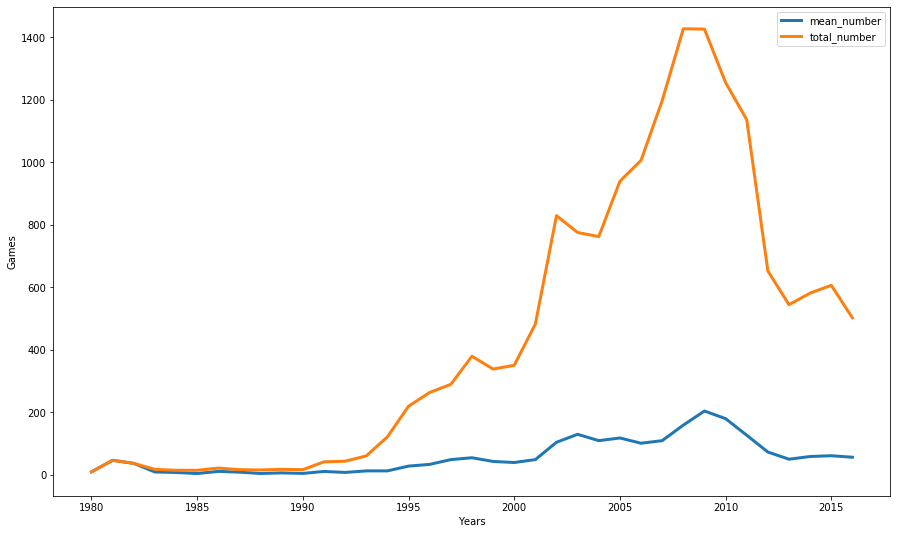

In [15]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)
plt.xlabel('Years')
plt.ylabel('Games')
plt.plot(mean_games_per_year, label='mean_number',linewidth=3)
plt.plot(total_games_per_year, label='total_number',linewidth=3)
plt.legend()

Однозначно нельзя сказать, начиная с какого года надо взять период. Однако видно, что с 2000 года колличество выпускаемых игр всреднем на платформу возрасло, а суммарное значение увеличилось на 2 порядка и достигло пика на рубеже 2010 года, после чего произошел спад.

**Посмотрим, как менялись продажи по платформам и выберем  платформы с наибольшими суммарными продажами.**

Создаем топ 10 лист по суммарным продажам игр на платформах за все время методом groupby, по столбцу platform, оставляя просуммировнный столбец total_sales

In [16]:
platform_list=games.groupby('platform')['total_sales'].sum().sort_values(ascending = False).index.values.tolist()[:10]

Выводим полученный список

In [17]:
platform_list

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

Создаем новый датафрем из games по запросу совпадения названия платформы в исходной таблице с названием платформы взятого из листа топ 10.

In [18]:
games_by_sales = games.query('platform in @platform_list')

Группируем полученную таблицу методом pivot table по суммарным продажам

In [19]:
games_platform = games_by_sales.pivot_table(
    index = 'year_of_release' ,
    columns= 'platform' ,values ='total_sales', aggfunc = sum)

Строим график продаж игр по каждой топ 10 платформ методом плот

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc27524abe0>,
      dtype=object)

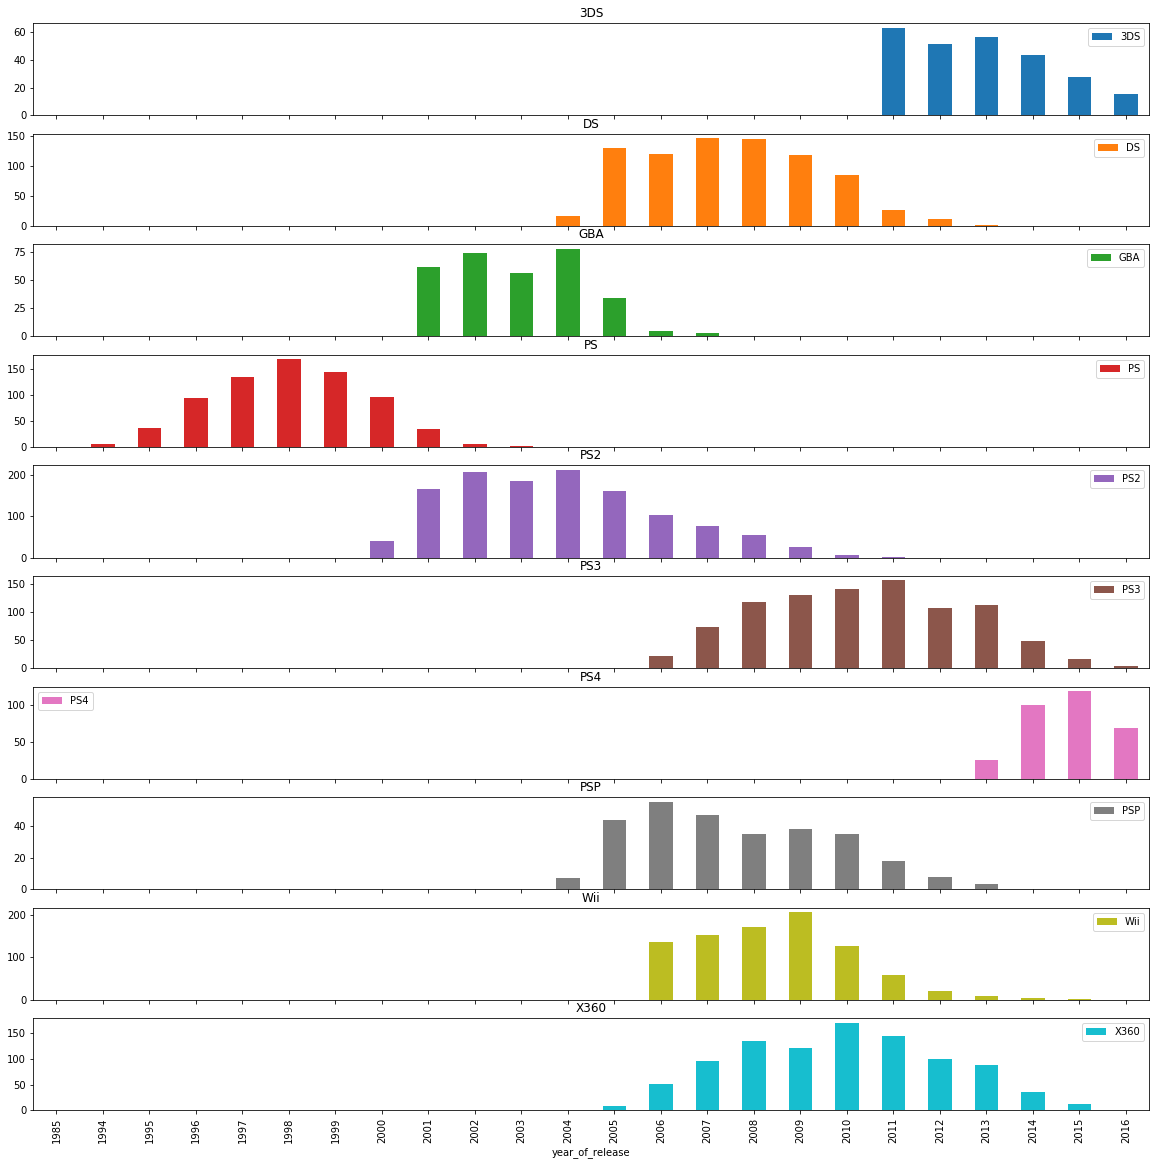

In [20]:
games_platform.plot(kind = 'bar',subplots ='platform',  figsize = (20,20));

На графике хорошо видно, как продажи по платформам начинают расти достигают своего пика и падают

**Определим за какой характерный срок появляются новые и исчезают старые платформы.**

Посчитаем среднее количество лет на рынке для каждой платформы. методом mean(). Видим, что в среднем платформы "живут" 10 лет.

In [21]:
years_on_market=games_platform.count().mean().round(0).astype(int)
years_on_market

10

**Определим актуальный период о продажах, который будет эффективен для построения проноза на 2017 год**.

Расчитаем начало этого периода, как разницу между, крайней датой занесенной в таблицу и средним колличесвтом лет рассчитанным в предыдущем пункте.

In [22]:
start_year = (games.query('platform in @platform_list')['year_of_release'].max() - games_platform.count().mean().round(0)).astype(int)
start_year

2006

Получаем 2006 год

**Уберем данные до 2006 года.**

Делаем это методом .query по условию >2006

In [23]:
games = games.query('year_of_release > 2006')

**Проанализируем, какие платформы лидируют по продажам, растут или падают и выберем несколько потенциально прибыльных платформ.**

Создадим таблицу games_platform, как таблицу суммарных  продаж по каждой платформе после 2006 года

In [24]:
games_platform = games.pivot_table(
    index = 'year_of_release' ,
    columns= 'platform' ,values ='total_sales', aggfunc = sum)

Для оценки потенциально прибыльной платформы, построим график изменения продаж для каждой платформы относительно предыдущего года. Т.е если продажи идут вверх, то значение процентного изменения будет положительным. Чтобы построить тако график, сначала воспользуемся методм .pct_change() и создадим новую таблицу games_rate_change

In [25]:
games_rate_change=games_platform.pct_change().replace(0, np.nan)
games_rate_change.head()

platform,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,1.0,-0.011093,NaN,NaN,0.338362,-0.290696,0.619347,NaN,-0.263797,NaN,0.121424,NaN,0.417671,-0.672727,NaN
2009,NaN,NaN,-0.177345,NaN,NaN,0.361514,-0.510204,0.104708,NaN,0.093488,NaN,0.208090,NaN,-0.110676,NaN,NaN
2010,NaN,NaN,-0.288774,NaN,NaN,0.435837,-0.786364,0.085847,NaN,-0.072525,NaN,-0.381794,NaN,0.413501,NaN,NaN
2011,NaN,NaN,-0.692072,NaN,NaN,0.442751,-0.920213,0.102764,NaN,-0.491438,NaN,-0.533802,NaN,-0.154032,NaN,NaN


Строим изменения продаж по платформе относительно предыдущего года

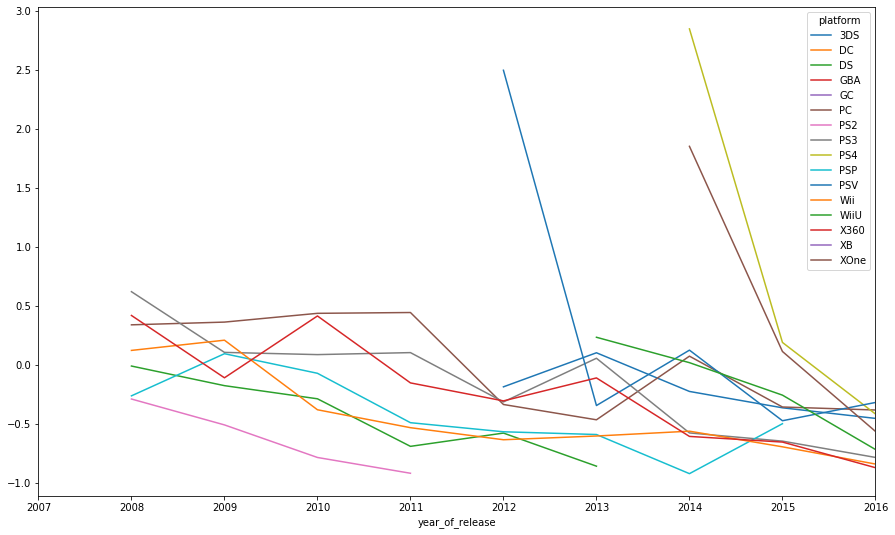

In [26]:
games_rate_change.plot()

**Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.**

Создадим лист, из платформ по среднему изменению продаж. Получаем, что лидирует платорма DC (это вылет, так как она продалавалась всего 2 года. т.е изменения будут равны 100%. Видно что, PS4 продается лучше всех, далее идут Xone, PSV, PC. 

In [27]:
games_rate_mean=games_rate_change.mean().sort_values(ascending = False)[:5].index.tolist()
games_rate_mean

['DC', 'PS4', 'XOne', 'PSV', 'PC']

#### Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

Строим график методом sns.boxtplot

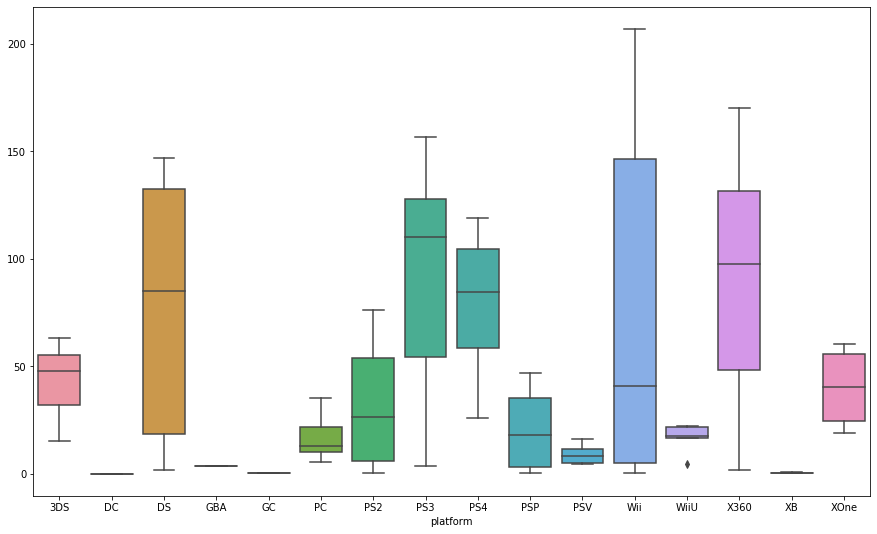

In [28]:
ax = sns.boxplot(data=games_platform)

Дополнительно выводим статистику методом describe()

In [29]:
games_platform.describe()

platform,3DS,DC,DS,GBA,GC,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
count,6.000000,2.000000,7.000000,1.0,1.00,10.000000,5.000000,10.000000,4.000000,9.000000,6.000000,10.000000,5.000000,10.000000,2.00000,4.000000
mean,42.968333,0.030000,76.505714,3.4,0.27,16.057000,32.476000,91.038000,78.535000,20.367778,8.968333,75.403000,16.438000,90.137000,0.36500,39.830000
std,18.278261,0.014142,63.326779,NaN,NaN,9.028435,32.152797,53.112204,40.567917,18.385661,4.729695,81.075756,7.068244,57.123728,0.26163,20.313977
min,15.140000,0.020000,1.540000,3.4,0.27,5.250000,0.450000,3.600000,25.990000,0.120000,4.250000,0.180000,4.600000,1.520000,0.18000,18.960000
25%,31.775000,0.025000,18.595000,3.4,0.27,10.055000,5.640000,54.117500,58.435000,3.140000,5.035000,4.960000,16.350000,48.200000,0.27250,24.352500
50%,47.560000,0.030000,85.020000,3.4,0.27,12.850000,26.400000,110.305000,84.625000,17.820000,8.420000,40.680000,17.560000,97.575000,0.36500,40.110000
75%,55.267500,0.035000,132.425000,3.4,0.27,21.642500,53.900000,127.827500,104.725000,35.040000,11.572500,146.565000,21.650000,131.517500,0.45750,55.587500
max,63.200000,0.040000,146.940000,3.4,0.27,35.030000,75.990000,156.780000,118.900000,46.930000,16.190000,206.970000,22.030000,170.030000,0.55000,60.140000


Из графика и таблицы видно, что платформы имеют, разные величины медианных продаж. По этой характеристике лидирует PS3, X360 (что и не удивительно, это самые популярные платформы). Разброс продаж также сильно меняется от платформы к платформе. Например на Wii он достигаетс 81 млн. при средних 75, те бывают игры, которые продаются хорошо, а бывает и резкий провал в продажах игры. У вырбанного лидера по динамике продаж PS4 все хорошо, игры имеют высокую медиану и не большой разброс, это значит, что плафторма стабильно выпускает хороший контент.

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Будем смотреть как влияют оценки критиков и пользоватетей на продажи внутри платформы PS4. 

Строим график sns.pairplot

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


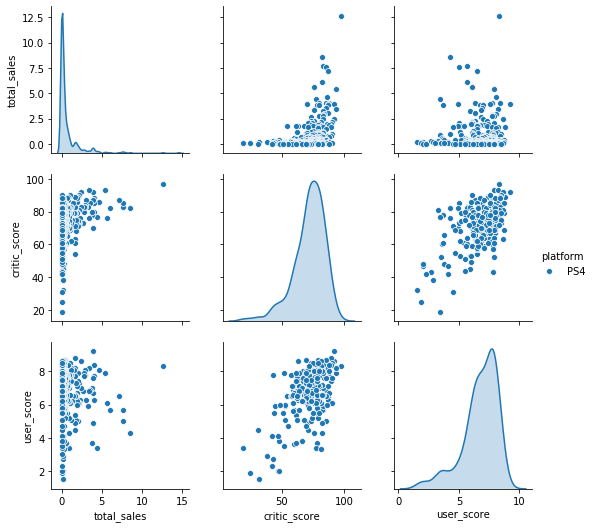

In [30]:
sns.pairplot(games.query('"PS4" in platform')
             [['total_sales', 'critic_score', 'user_score', 'platform']],
             kind='scatter', hue  = 'platform')

Для колличественной оценки сходимости найдем коэффициент пирсона.

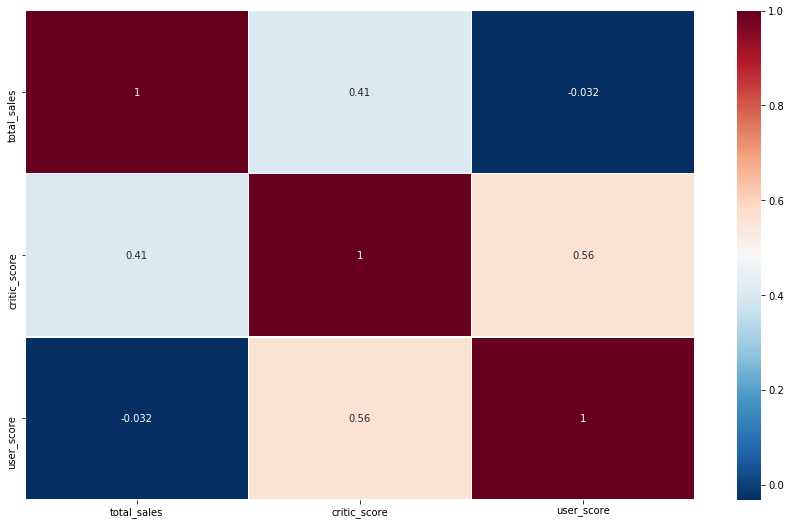

In [31]:
pearsoncorr = games.query('"PS4" in platform')[['total_sales', 'critic_score', 'user_score', 'platform']].corr(method='pearson')

sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

Из графика видно, что визуально корреляцию имеют только оценки пользователей и критиков м/у собой, но это не подтверждается коэффициентом пирсона. Остальные пары даже визуально не коррелируются, пирсон это подтверждает. Вывод рейтинги не влияют критиков и пользователей не влияют на продажи.

#### Соотнесите выводы с продажами игр на других платформах.

Аналогично построим парные графики для остальных платформ.

In [32]:
games_nonNan = games.dropna().reset_index(drop= True)

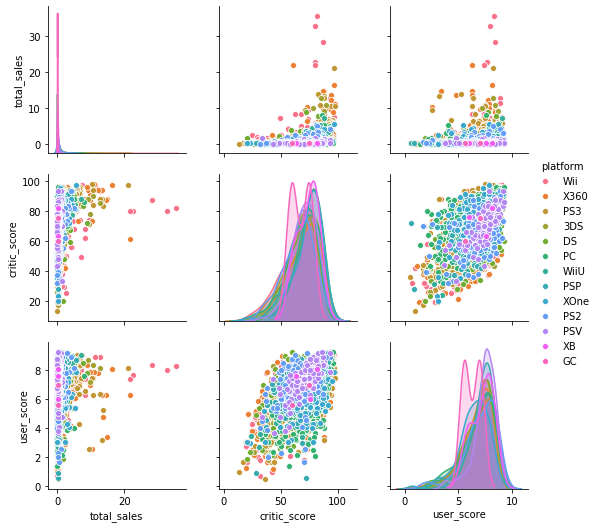

In [33]:
sns.pairplot(games_nonNan.query('"PS4" not in platform')
             [['total_sales', 'critic_score', 'user_score', 'platform']],
             kind='scatter', hue  = 'platform')

Из графиков видно, что визуально корреляцию  имеют только оценки пользователей и критиков м/у собой. Пары включающие глобальные продажи  даже визуально не коррелируются. Вывод рейтинги не влияют критиков и пользователей не влияют на продажи.
Вывод рейтинги не влияют!!!

**Посмотрим на общее распределение игр по жанрам.**

Создадим сводную таблицу по жанрам games_genre методом pivot_table.

In [34]:
games_genre = games.pivot_table(
    index = 'year_of_release' ,
    columns= 'genre' ,values ='total_sales', aggfunc = sum)

Выведем получившуюся таблицу и построим box plot по ней

In [35]:
games_genre.head(5)

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2007,104.85,24.13,17.49,91.46,35.07,23.56,38.78,43.46,70.61,48.35,97.73,9.26
2008,134.96,24.63,35.02,86.06,35.13,15.23,70.04,58.98,59.16,46.11,94.58,11.60
2009,137.69,20.23,31.90,75.81,40.53,19.79,33.69,47.31,69.29,32.92,137.37,12.29
2010,115.29,15.96,14.69,95.14,31.04,10.75,34.37,69.65,76.83,21.49,91.24,13.68
2011,116.68,15.61,22.41,54.38,27.68,4.96,34.81,52.83,98.18,15.14,56.08,8.82


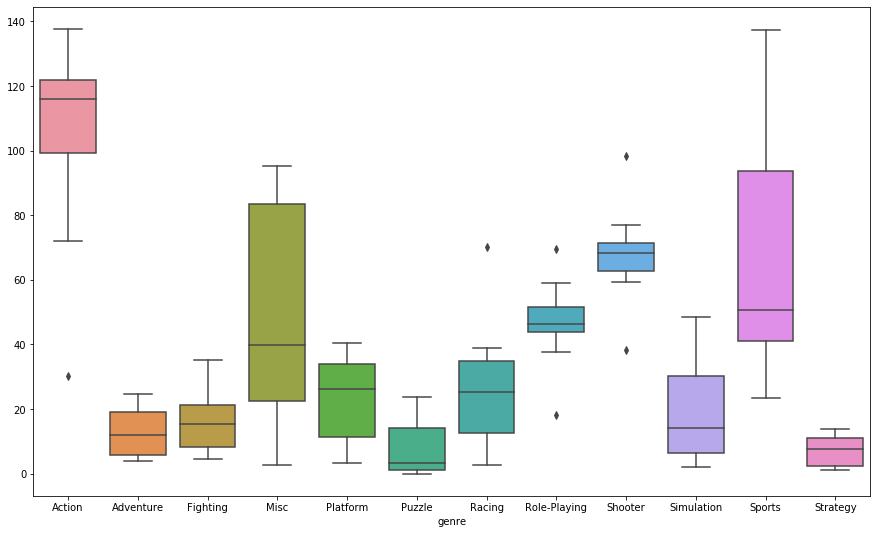

In [36]:
sns.boxplot(data=games_genre)

Дополнительно выведем анализ методом descibe.

In [37]:
games_genre.describe()

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
count,10.000000,10.0000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000
mean,105.059000,12.9990,16.600000,48.789000,23.045000,7.918000,26.519000,46.503000,67.88000,19.913000,65.807000,6.899000
std,32.446126,8.0940,10.437478,35.812941,13.291461,8.809665,19.982434,13.446629,14.98049,16.974018,37.132931,4.877001
min,30.110000,3.8200,4.470000,2.600000,3.230000,0.010000,2.790000,18.180000,38.22000,1.890000,23.490000,0.980000
25%,99.135000,5.8650,8.220000,22.510000,11.200000,1.092500,12.680000,43.707500,62.83250,6.402500,40.922500,2.202500
50%,115.985000,11.8850,15.270000,39.825000,26.110000,3.340000,25.175000,46.265000,68.40000,14.250000,50.615000,7.470000
75%,121.695000,19.1625,21.180000,83.497500,34.062500,14.110000,34.700000,51.450000,71.46500,30.062500,93.745000,11.015000
max,137.690000,24.6300,35.020000,95.140000,40.530000,23.560000,70.040000,69.650000,98.18000,48.350000,137.370000,13.680000


**Выделяются ли жанры с высокими и низкими продажами? Зависит от того как смотреть.**

Однозначный лидер жанров это action. У этого жанра среднее и медиана практически не отличаются и находся на самом высоком уровне. Т.е если делать стваку на продажи то лучше брать игру action. На втором месте шутеры, примечательно они имеют низкий разброс, т.е шутеры достаточно просто прогназиурются в своих продажах. Спорт и misic продаются неоднозначно. Ниже всего в рейтинге пазлы.

**Вывод**

Тезисно можно сделать следующие подвыводы.
- В среднем платформы живут десять лет, те мы будем делать наш анализ на играх чей выпуск был позже 2006 года.
- Однозначный лидер продаж на 2016 год PS4, за ним Xone, т.е если делать ставки на игры, то в идеале они должны выпускаться на эти две платформы.
- По жанрам все предпочитают action и шутеры, а вот на пазлы лучше надежду не возлагать.

# Этап 4 Составления  портрет пользователя каждого региона

Анализ портрета пользователя по регионам будем делать визуально с помощью барплотов. Для начала создадим упрощенную таблицу, где оставим только данные о платформе, жанрах и регоинах продаж

In [38]:
games_all = games[['platform','genre','rating','eu_sales', 'na_sales','jp_sales'  ]]
games_all.head()

,platform,genre,rating,eu_sales,na_sales,jp_sales
2,Wii,Racing,E,12.76,15.68,3.79
3,Wii,Sports,E,10.93,15.61,3.28
8,Wii,Platform,E,6.94,14.44,4.70
13,Wii,Sports,E,8.03,8.92,3.60
14,X360,Misc,E,4.89,15.00,0.24


Построим девять графиков по 2 циклам. Верхний цикл регион продаж, нижний цикл параметр сравнения, либо платформа, рейтинг или жанр. Выведем все графкими методом plot.bar

<Figure size 864x864 with 0 Axes>

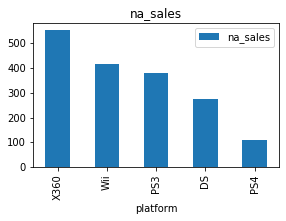

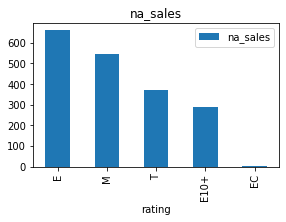

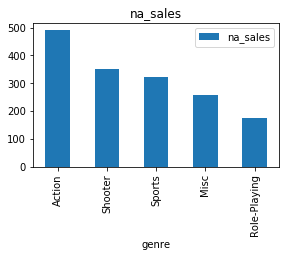

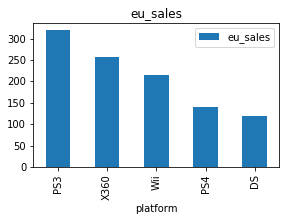

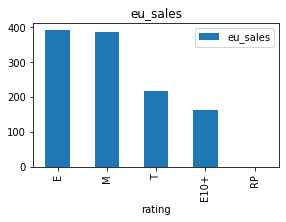

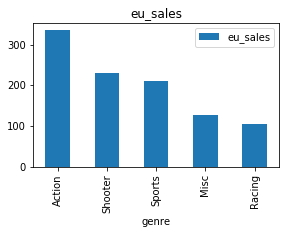

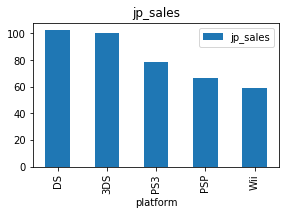

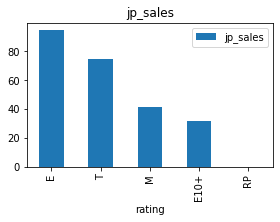

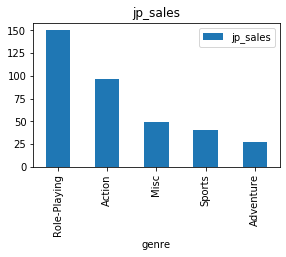

In [39]:
plt.figure(figsize=(12, 12))
list_one = ['na_sales', 'eu_sales', 'jp_sales']
list_two = ['platform', 'rating', 'genre']
for group_one in list_one:
    for group_two in list_two:
        games_new =games_all.groupby(group_two)[group_one].sum().sort_values(ascending = False)[:5].to_frame()
        games_new.plot.bar( subplots= True, layout=(3,3))

**Определите для пользователя каждого региона (NA, EU, JP):**

**Вывод**

**Самые популярные платформы (топ-5).**
На первом метсе в европе PS3, в Америке X360, а в японии DS (япония такая япония). С 2 - по 5 место предпочтения америки и европы не сильно отличаются, в целом европа и америка имеет одинаковые вкусы. В японии же приставки DS и 3DS PSP захватили рынок, данный факт надо учитыват при прогнозе продаж игр. Если ориентироваться на продажи, то европа и америка будет лидировать, соответсвенно на эту части рынка надо обращать особое внимание. Надо сказать, что это самые популярные платформы за 10 лет, но самая перспектиные по прежнему остаются PS4 и Xone (поэтому делаем упор именно на них)

**Самые популярные жанры (топ-5). Поясните разницу.**
Опять рынок амрики и европы практически идентичен лидирует Action, затем идет Shooter после	Sports и Misc или Racing делят 4 и 5 место. Для этих 2 регионов, вкусы пользователей понятны, лучше делать упор на аction. В Японии все немного подругому аction занимает почетное второе место а role playing 1. В общем по всему миру всем нравится action/


**Влияет ли рейтинг ESRB на продажи в отдельном регионе?** 
Рейтинги ESRB весде одинаковы для всех регионов, те нам не придется подстравиться под каждый рынок, что уже хорошо.

# Этап 5. Проверьте гипотезы

**Гипотеза:Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

Для проведения проверки гипотиз сначала создадим 2 выборки, в первую включим Xbox во вторую PS методом query

In [40]:
XOne=games.query('"XOne" in platform')[ 'user_score']
PC=games.query('"PC" in platform')[ 'user_score']

Критический уровень статистической значимости примем как 0.05, если p-value окажется меньше него - отвергнем гипотезу

Проверка гипотезы будет состоять из проверки двух выборок через result.pvalue.

In [41]:
alpha = .05
results = st.ttest_ind(
    XOne, PC)

print('Среденее PC: {:.2}, Среденее XOne {:.2}' .format(PC.mean(),XOne.mean()))

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среденее PC: 6.8, Среденее XOne 6.5
p-значение: nan
Не получилось отвергнуть нулевую гипотезу


Можно сделать вывод, что нулевая гипотеза, говорящая что две среднии двух выборок равны, не может быть отвергнута. 

**Гипотеза:Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.**

Для проведения проверки гипотиз сначала создадим 2 выборки, в первую включим action во вторую sports методом query

За нулевую гипотезу примим что два жанра имеют одинаковые рейтинги, если нулевая гипотезе не подтвердиться, то можно говорить, что их рейтинги разные

In [42]:
Action = games.query('"Action" in genre')['user_score']
Sports = games.query('"Sports" in genre')['user_score']

In [43]:
alpha = .05  # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    Action, Sports)

print('Среденее Action: {:.2}, Среденее Sports {:.2}' .format(Action.mean(),Sports.mean()))

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Среденее Action: 6.8, Среденее Sports 6.3
p-значение: nan
Не получилось отвергнуть нулевую гипотезу


Так как не получилось отвергнуть нулевую гипотезу, нельзя сделать вывод, что рейтинги жанров аction и sports отличаются.

# Общий вывод

**Отвечая на главный вопрос, на какой потенциальный продукт делать ставку, рекомендуется выбрать платформу ps4 и подобрать игру из жанра action**

Во время выполнения анализа были сделаны следующие шаги

- Выявлены проблемы с типами данных. Пропуски оставили как есть, удалять на стали
- Построены графики продолжительности жизни платформы и найдена средняя величина 10 лет.
- Выяснено, что самая продающая платформа PS4, а жанр экшн
- Зависимости м/у продажами и рейтингом игр не обнаружено
- Составлен портрет пользователей по регонам, америка и европа похожи, япония сильно отличается по платформам, по жарнам экшн в всегда в топ 3
- Предположенные гипотезы о рейтингах платформ и рейтингов жанров не подтвердились
